In [ ]:
#NOTE need to resample the 
'''
wb_command -label-resample \
  L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.10k_fs_LR.label.gii \
  spheres/MacaqueYerkes19.L.sphere.10k_fs_LR.surf.gii \
  spheres/MacaqueYerkes19.L.sphere.32k_fs_LR.surf.gii \
  ADAP_BARY_AREA \
  L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.32k_fs_LR.label.gii \
  -area-surfs \
  surfaces/MacaqueYerkes19.L.midthickness.10k_fs_LR.surf.gii \
  surfaces/MacaqueYerkes19.L.midthickness.32k_fs_LR.surf.gii \
  -largest
'''


In [101]:
#script to analyze macaque data, use niwrap3912
import nibabel as nib
import pyvista as pv
import yaspy
import numpy as np
import sys
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

# In Jupyter, __file__ is not defined, so use the notebook directory as a reference
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '../092325_cortical_gradients')))
from gradient_utils import *

template_path = '/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/parcellation/macaque/MacaqueYerkes19_v1.2_Vj_976nz/MNINonLinear/fsaverage_LR32k/MacaqueYerkes19_v1.2.L.midthickness.32k_fs_LR.surf.gii'
atlas_path = '/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/parcellation/macaque/L.Schaefer2018_400Parcels_7Networks_order.human-to-monkey.32k_fs_LR.label.gii'
atlas_data_lh = nib.load(atlas_path).darrays[0].data

base_path = '/Users/dennis.jungchildmind.org/Desktop/thomas-macaquedat/'
total_path = f'{base_path}/macaque_cortical_thickness_thickness_smooth1.0mm_32k_6mm_fwhm.shape.gii'
supra_path = f'{base_path}/macaque_infragranular_thickness_thickness_smooth1.0mm_32k_6mm_fwhm.shape.gii'
infra_path = f'{base_path}/macaque_supragranular_thickness_thickness_smooth1.0mm_32k_6mm_fwhm.shape.gii'


total_thickness = nib.load(total_path).darrays[0].data
supra_thickness = nib.load(supra_path).darrays[0].data
infra_thickness = nib.load(infra_path).darrays[0].data

(200,)
1 200
atlas_data 32492


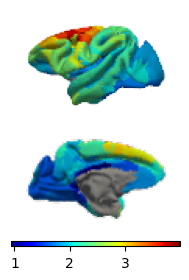

(200,)
1 200
atlas_data 32492


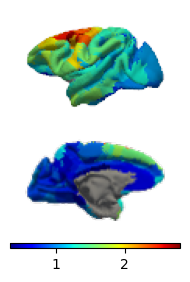

(200,)
1 200
atlas_data 32492


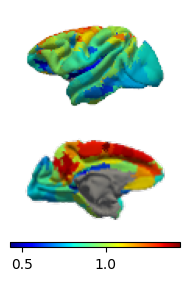

(200,)
1 200
atlas_data 32492


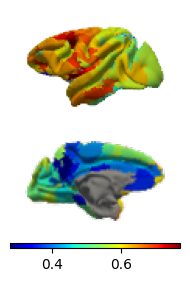

(200,)
1 200
atlas_data 32492


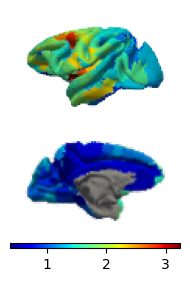

In [102]:
#layer type
lh_surf = template_path#'/Users/dennis.jungchildmind.org/Downloads/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'

def mapping_to_atlas(data_parc, atlas_data):
    mapped_values = np.zeros(len(atlas_data))
    print('atlas_data', len(atlas_data))
    for i in range(len(atlas_data)):
        atlas_val = atlas_data[i] #this just gets the parcel index of the atlas (1...400 for Schaefer 400 atlas)
        if atlas_val != 0:
            mapped_values[i] = data_parc[atlas_val-1] 
        else:
            mapped_values[i] = np.nan
    
    return mapped_values
    
def process_hemisphere(data_parc, atlas_data, surf_path, hemi,  vmin=None, vmax=None,cmap = 'jet'):
    plotters_mean = []
    plotters_var = []
    
    # Calculate overall stats
    if data_parc.ndim != 1:
        means = [np.nanmean(data_parc, axis=1)][0]
    else:
        means = data_parc

    print(means.shape)
  
    #
    min_atlas = np.nanmin(atlas_data[atlas_data != 0])
    max_atlas = np.nanmax(atlas_data[atlas_data != 0])
    print(min_atlas, max_atlas)

    mean_surfaces = mapping_to_atlas(means, atlas_data)
    #mean_surfaces = means
        
    # Set visualization parameters based on layer type
    vmin_mean = np.round(np.nanmin(mean_surfaces), decimals=2) if vmin is None else vmin
    vmax_mean = np.round(np.nanmax(mean_surfaces), decimals=2) if vmax is None else vmax



    # Generate plots
    plotter_mean = yaspy.Plotter(surf_path, hemi=hemi)
    overlay_mean = plotter_mean.overlay(mean_surfaces, cmap=cmap, alpha=1, 
                                     vmin=vmin_mean, vmax=vmax_mean)
    plotter_mean.border(mean_surfaces, alpha=0)
    plotters_mean.append([plotter_mean.screenshot("lateral"), 
                        plotter_mean.screenshot("medial"), 
                        overlay_mean])

                       
    return plotters_mean, vmin_mean, vmax_mean



# Create montages
def create_montage(plotters):
    return yaspy.montage([[p[0] for p in plotters], [p[1] for p in plotters]], 
                        pad=10, shareh=True, sharew=True)



# Plot results
def plot_hemispheres(img_lh=None, img_rh=None, plotters_lh=None, plotters_rh=None,vmin=None, vmax=None):
    if img_lh is None and img_rh is not None:
        # Only plot RH
        f, ax = plt.subplots(1, 1, figsize=(2,3))
        ax.imshow(img_rh)
        ax.axis('off')
        # Add colorbar for RH
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="2.5%", pad=0.05)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=plotters_rh[0][2].get_cmap())
        plt.colorbar(sm, cax=cax, orientation="horizontal")
        plt.tight_layout()
        plt.show()
    elif img_rh is None and img_lh is not None:
        # Only plot LH
        f, ax = plt.subplots(1, 1, figsize=(2,3))
        ax.imshow(img_lh)
        ax.axis('off')
        # Add colorbar for LH
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="2.5%", pad=0.05)
        sm = plt.cm.ScalarMappable(norm=norm, cmap=plotters_lh[0][2].get_cmap())
        plt.colorbar(sm, cax=cax, orientation="horizontal")
        plt.tight_layout()
        plt.show()
    elif img_lh is not None and img_rh is not None:
        # Plot both LH and RH
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(4,3))
        
        ax1.imshow(img_lh)      
        ax1.axis('off')
        
        ax2.imshow(img_rh)
        ax2.axis('off')
        
        # Add colorbars with same normalization
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        for ax, plotters in [(ax1, plotters_lh), (ax2, plotters_rh)]:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("bottom", size="2.5%", pad=0.05)
            sm = plt.cm.ScalarMappable(norm=norm, cmap=plotters[0][2].get_cmap())
            plt.colorbar(sm, cax=cax, orientation="horizontal")
        plt.tight_layout()
        plt.show()
    else:
        # Both are None, nothing to plot
        print("Both hemispheres are None, nothing to plot.")


lh_data_parc_total = parcellate_data(total_thickness, atlas_data_lh)
lh_data_parc_total[lh_data_parc_total == 0] = np.nan

lh_data_parc_supra = parcellate_data(supra_thickness, atlas_data_lh)
lh_data_parc_supra[lh_data_parc_supra == 0] = np.nan

lh_data_parc_infra = parcellate_data(infra_thickness, atlas_data_lh)
lh_data_parc_infra[lh_data_parc_infra == 0] = np.nan

lh_data_parc_ratio = lh_data_parc_supra / lh_data_parc_total

lh_data_parc_relative = lh_data_parc_supra / lh_data_parc_infra

for data_parc, title in zip([lh_data_parc_total, lh_data_parc_supra, lh_data_parc_infra, lh_data_parc_ratio, lh_data_parc_relative], ['total', 'supra', 'infra', 'ratio', 'relative']):     
    plotters_lh_mean, vmin_lh, vmax_lh = process_hemisphere(data_parc, atlas_data_lh, lh_surf, 'lh')
    #plotters_rh_mean, vmin_rh, vmax_rh = process_hemisphere(rh_data_parc, atlas_data_rh, rh_surf, 'rh',vmin=vmin_lh, vmax=vmax_lh)

    plot_hemispheres( create_montage(plotters_lh_mean), None, plotters_lh_mean, plotters_rh_mean,vmin=vmin_lh, vmax=vmax_lh)

#save the data
dat_save_path = os.path.join(base_path, 'data')
if not os.path.exists(dat_save_path):
    os.makedirs(dat_save_path)
np.savez(
    os.path.join(dat_save_path, 'lh_data_parc_macaque_schaefer400.npz'),
    total=lh_data_parc_total,
    supra=lh_data_parc_supra,
    infra=lh_data_parc_infra,
    ratio_supra=lh_data_parc_ratio,
    relative=lh_data_parc_relative
)



